In [33]:
import scenic
from scenic.simulators.carla.simulator import CarlaSimulator
from scenic.syntax.veneer import localPath
from scenic.core.regions import MeshVolumeRegion
from rulebook_benchmark.realization import Realization

In [34]:
MAX_STEPS = 300 # 30 seconds
realization = Realization(MAX_STEPS)
scenario = scenic.scenarioFromFile('pedestrian_collision.scenic', params={"realization":realization}, mode2D=True)
scene, _ = scenario.generate()
simulator = CarlaSimulator(carla_map = 'Town01', map_path = localPath('../maps/Town01.xodr'))
simulation = simulator.simulate(scene, maxSteps=MAX_STEPS)

ERROR: failed to destroy actor 1310 : unable to destroy actor: not found 


MovieWriter ffmpeg unavailable; using Pillow instead.


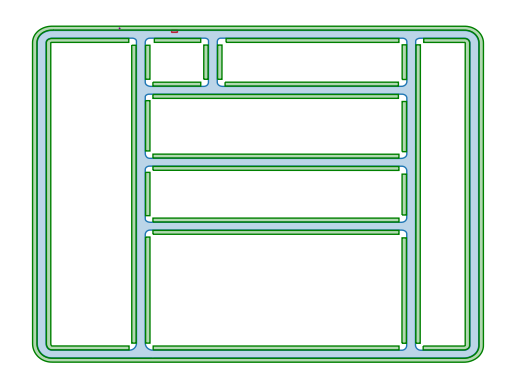

In [ ]:
import shapely

import shapely.plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ego = realization.get_ego()
adv = realization.get_object(1)
network = realization.network

multiplier = 1

drivable_region = network.drivableRegion
walkable_region = network.walkableRegion
def update(frame):
    ax.clear()
    frame = frame*multiplier
    
    ego_state = ego.get_state(frame)
    
    
    ego_region = MeshVolumeRegion(mesh=ego.mesh, dimensions=ego.dimensions, rotation=ego_state.orientation, position=ego_state.position)
    
    
    shapely.plotting.plot_polygon(ego_region.boundingPolygon.polygons, ax=ax, add_points=False, color='red')    
    shapely.plotting.plot_polygon(drivable_region.polygons, ax=ax, add_points=False)
    shapely.plotting.plot_polygon(walkable_region.polygons, ax=ax, add_points=False, color='green')
    
    for adv in realization.objects_non_ego:
        if adv.object_type == 'Pedestrian':
            color = 'purple'
        else:
            color = 'blue'
        adv_state = adv.get_state(frame)
        adv_region = MeshVolumeRegion(mesh=adv.mesh, dimensions=adv.dimensions, rotation=adv_state.orientation, position=adv_state.position)
        shapely.plotting.plot_polygon(adv_region.boundingPolygon.polygons, ax=ax, add_points=False, color=color)
    ax.set_xticks([])
    ax.set_yticks([])
    #delete frame around plot
    for spine in ax.spines.values():
        spine.set_visible(False)


    
fig, ax = plt.subplots()

anim = animation.FuncAnimation(fig, update, frames=MAX_STEPS//multiplier, repeat=False)
save_path = "scenario.gif"
anim.save(save_path, fps=30)



    

In [36]:
from rulebook_benchmark.rule_functions import rule_vru_collision, rule_vehicle_collision, rule_stay_in_drivable_area, vru_clearance_on_road, vru_clearance_off_road, vru_acknowledgement
results = [rule_vru_collision(realization), rule_vehicle_collision(realization), rule_stay_in_drivable_area(realization), vru_clearance_off_road(realization), vru_clearance_on_road(realization), vru_acknowledgement(realization, proximity = 5)]

max_violations = [x[0] for x in results]
violation_histories = [x[1] for x in results]

print("Max violations: ", max_violations)
print("Violation histories: ", violation_histories)

Max violations:  [25.941209638258645, 0, 4.675924124196909, 2.0, 2.0, 6.763632339401796]
Violation histories:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.952124548356048, 6.72952510564715, 6.72952510564715, 6.72952510564715, 7.3113799506099975, 7.893234795572845, 7.939576842214026, 7.9872482694801334, 8.058292381120195, 8.129336492760256, 8.18384602855402, 8.241242468368801, 8.301069213479742, 8.367575135092856, 8.654643003761432, 8.941710872430008, 9.32841280866446, 10.061007114618395, 10.953293018871713, 12.881401549356696, 14.809510079841678, 17.580615425933335, 20.35172077202499, 20.35172077202499, 20.35172077202499, 20.35172077202499, 20.35172077202499, 20.35172077202499, 20.35172077202499, 20.35172077202499, 

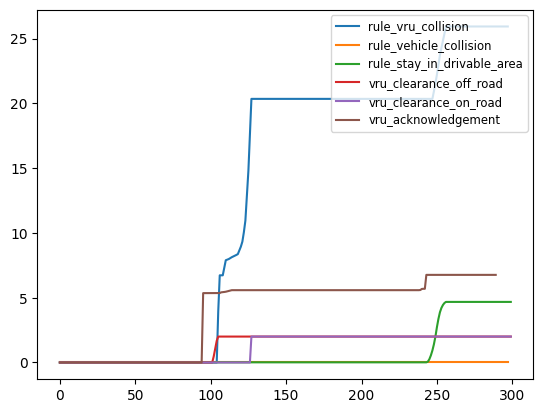

In [37]:
for history in violation_histories:
    plt.plot(history)
plt.legend(["rule_vru_collision", "rule_vehicle_collision", "rule_stay_in_drivable_area", "vru_clearance_off_road", "vru_clearance_on_road", "vru_acknowledgement"], loc='upper right', fontsize='small')
#make legend smaller
plt.savefig("violation_histories.png")
plt.show()
